# Ski Resort Price Regression Capstone

This project centers on building a data-driven model that predicts day-pass prices for ski resorts using detailed resort attributes. We focus on mountains’ geographic context, elevation profile, trail difficulty mix, and lift infrastructure to create informative features. Amenities such as snowparks, night skiing, and child-focused services are included to capture experiential value. The modeling effort frames the problem as supervised regression, enabling quantitative estimates for new or planned resorts. Stakeholders can input a prospective resort’s characteristics and receive a recommended price benchmark. 

The project includes data preparation, feature engineering, and exploratory analysis to understand patterns before modeling. Multiple regression algorithms will be compared to find the best balance of accuracy and interpretability. Resulting insights help planners align pricing with market expectations while identifying attributes that command higher ticket prices.


We begin by importing the core analysis libraries: pandas and numpy for data handling, plus matplotlib.pyplot and seaborn for visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Let's take a look at the first few rows of the dataset to understand its structure and contents.

In [2]:
raw_data = pd.read_csv("resorts.csv", encoding="cp1252")

In [3]:
raw_data

,ID,Resort,Latitude,Longitude,Country,Continent,Price,Season,Highest point,Lowest point,...,Snow cannons,Surface lifts,Chair lifts,Gondola lifts,Total lifts,Lift capacity,Child friendly,Snowparks,Nightskiing,Summer skiing
0,1,Hemsedal,60.928244,8.383487,Norway,Europe,46,November - May,1450,620,...,325,15,6,0,21,22921,Yes,Yes,Yes,No
1,2,Geilosiden Geilo,60.534526,8.206372,Norway,Europe,44,November - April,1178,800,...,100,18,6,0,24,14225,Yes,Yes,Yes,No
2,3,Golm,47.057810,9.828167,Austria,Europe,48,December - April,2110,650,...,123,4,4,3,11,16240,Yes,No,No,No
3,4,Red Mountain Resort-Rossland,49.105520,-117.846280,Canada,North America,60,December - April,2075,1185,...,0,2,5,1,8,9200,Yes,Yes,Yes,No
4,5,Hafjell,61.230369,10.529014,Norway,Europe,45,November - April,1030,195,...,150,14,3,1,18,21060,Yes,Yes,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,Puigmal,42.395007,2.108883,France,Europe,0,Unknown,2700,1830,...,0,11,2,0,13,11865,Yes,No,No,No
495,496,Kranzberg-Mittenwald,47.451359,11.228630,Germany,Europe,29,December,1350,980,...,8,9,1,0,10,5850,Yes,Yes,Yes,No
496,497,Wetterstein lifts-Wettersteinbahnen-– Ehrwald,47.406897,10.927998,Austria,Europe,43,December - March,1530,1000,...,33,6,4,0,10,5425,Yes,Yes,No,No
497,498,Stuhleck-Spital am Semmering,47.574195,15.789964,Austria,Europe,42,April,1774,777,...,240,7,2,0,9,14400,Yes,Yes,Yes,No


We can see we have 499 different ski resorts in our dataset. Some of the information is irrelevant to our use case, such as the resort name.  It could be possible the price is affected by the name of the resort, but for our use case we can ignore the resort name.   

Let's look at the data closer.

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   499 non-null    int64  
 1   Resort               499 non-null    object 
 2   Latitude             499 non-null    float64
 3   Longitude            499 non-null    float64
 4   Country              499 non-null    object 
 5   Continent            499 non-null    object 
 6   Price                499 non-null    int64  
 7   Season               499 non-null    object 
 8   Highest point        499 non-null    int64  
 9   Lowest point         499 non-null    int64  
 10  Beginner slopes      499 non-null    int64  
 11  Intermediate slopes  499 non-null    int64  
 12  Difficult slopes     499 non-null    int64  
 13  Total slopes         499 non-null    int64  
 14  Longest run          499 non-null    int64  
 15  Snow cannons         499 non-null    int

## Pre-Processing the data

Some of these data types are "objects" and it will be difficult for the machine learning model to ingest those data types. We will need to do some pre-processing to account for non-numerical data types. 

Our model can’t work with raw strings, so we’ll one-hot encode the country and continent fields. That creates a binary indicator for each possible location. Exactly one flag flips to 1 for any given resort, and the rest stay 0, making the model’s comparisons straightforward.

The Season field gets split into separate start and end months so the model can read it more easily. Because some entries cover multiple seasons, we’ll address those multi-period cases before the initial split. These months will then need to be mapped to numerical values.

The Child friendly, Snowparks, Nightskiing, and Summer skiing columns are already Yes/No, so we simply convert them to 0/1 indicators to keep everything numeric.

We also notice that we are not missing any values with 499 non-null cells in each column.  This is good because we are assured the dataset is complete, and we don't have to worry about stripping out any incomplete data rows.

In [5]:
num_countries = raw_data["Country"].nunique()
num_countries

38

In [6]:
df_encoded = pd.get_dummies(raw_data, columns=['Country', 'Continent'], drop_first=False)
for col in df_encoded.columns:
    if df_encoded[col].dtype == bool:
        df_encoded[col] = df_encoded[col].astype('int8')
df_encoded.head()

,ID,Resort,Latitude,Longitude,Price,Season,Highest point,Lowest point,Beginner slopes,Intermediate slopes,...,Country_Switzerland,Country_Turkey,Country_Ukraine,Country_United Kingdom,Country_United States,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America
0,1,Hemsedal,60.928244,8.383487,46,November - May,1450,620,29,10,...,0,0,0,0,0,0,1,0,0,0
1,2,Geilosiden Geilo,60.534526,8.206372,44,November - April,1178,800,18,12,...,0,0,0,0,0,0,1,0,0,0
2,3,Golm,47.057810,9.828167,48,December - April,2110,650,13,12,...,0,0,0,0,0,0,1,0,0,0
3,4,Red Mountain Resort-Rossland,49.105520,-117.846280,60,December - April,2075,1185,20,50,...,0,0,0,0,0,0,0,1,0,0
4,5,Hafjell,61.230369,10.529014,45,November - April,1030,195,33,7,...,0,0,0,0,0,0,1,0,0,0


Above we have added a column for each country. This may seem like a lot of columns, but the machine learning model will appreciate the straight forward binary approach. 

Lets split the seasons up now. It is important to note that any resorts with multiple seasons will need to be dropped since they are anamolies in the dataset.

In [7]:
df_encoded['Season'] = (df_encoded['Season']
    .str.replace('–', '-', regex=False)
    .str.replace('—', '-', regex=False)
    .str.strip())
pattern = r'^\s*[A-Za-z]+(?: [A-Za-z]+)*\s*-\s*[A-Za-z]+(?: [A-Za-z]+)*\s*$'
df_season = df_encoded[df_encoded['Season'].str.match(pattern, na=False)].copy()
season_parts = df_season['Season'].str.extract(r'^\s*(?P<SeasonStart>.+?)\s*-\s*(?P<SeasonEnd>.+?)\s*$')
df_season = df_season.join(season_parts)
df_season = df_season.drop(columns=['Season'])
df_season[['SeasonStart','SeasonEnd']]

,SeasonStart,SeasonEnd
0,November,May
1,November,April
2,December,April
3,December,April
4,November,April
...,...,...
490,November,April
491,December,April
493,December,April
496,December,March


Now we can see the seasons have been split using a regex pattern. 

The next question is how can we transform the months into integers or binary? We can map each month to an integer given that months are ordinal and follow a cyclical structure. We can map January to 1, February to 2, and so on. 

In [8]:
from math import pi
month_to_num = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

By using cyclic encoding we can ensure 1 is equidistant from 12 as it is from 2. In lamen terms, we want the machine learning model to understand that January is only one unit away from December, even though 1 is 11 units away from 12 away on a linear number line. For that we can use calculus with the unit circle and map each month to a point on the unit circle. By mapping our old number line onto a unit circle, we can preserve the ordinality of each month and the sequence of the year. Each month is mapped to a sine and cosine coordinate on the unit circle.

In [9]:
angles = {m: 2 * np.pi * idx / 12 for m, idx in month_to_num.items()}
month_to_sin = {m: np.sin(theta) for m, theta in angles.items()}
month_to_cos = {m: np.cos(theta) for m, theta in angles.items()}

df_season['SeasonStart_sin'] = df_season['SeasonStart'].map(month_to_sin)
df_season['SeasonStart_cos'] = df_season['SeasonStart'].map(month_to_cos)
df_season['SeasonEnd_sin'] = df_season['SeasonEnd'].map(month_to_sin)
df_season['SeasonEnd_cos'] = df_season['SeasonEnd'].map(month_to_cos)

df_season[['SeasonStart', 'SeasonStart_sin', 'SeasonStart_cos', 'SeasonEnd', 'SeasonEnd_sin', 'SeasonEnd_cos']]

,SeasonStart,SeasonStart_sin,SeasonStart_cos,SeasonEnd,SeasonEnd_sin,SeasonEnd_cos
0,November,-5.000000e-01,0.866025,May,0.500000,-8.660254e-01
1,November,-5.000000e-01,0.866025,April,0.866025,-5.000000e-01
2,December,-2.449294e-16,1.000000,April,0.866025,-5.000000e-01
3,December,-2.449294e-16,1.000000,April,0.866025,-5.000000e-01
4,November,-5.000000e-01,0.866025,April,0.866025,-5.000000e-01
...,...,...,...,...,...,...
490,November,-5.000000e-01,0.866025,April,0.866025,-5.000000e-01
491,December,-2.449294e-16,1.000000,April,0.866025,-5.000000e-01
493,December,-2.449294e-16,1.000000,April,0.866025,-5.000000e-01
496,December,-2.449294e-16,1.000000,March,1.000000,6.123234e-17


Now that we have the sine and cosine coordinates for each month, we can remove the associated season columns.

In [10]:
df_season = df_season.drop(columns=['SeasonStart', 'SeasonEnd'])
season_cols = ['SeasonStart_sin', 'SeasonStart_cos', 'SeasonEnd_sin', 'SeasonEnd_cos']
df_season = df_season.dropna(subset=season_cols)
df_season.shape
df_season

,ID,Resort,Latitude,Longitude,Price,Highest point,Lowest point,Beginner slopes,Intermediate slopes,Difficult slopes,...,Country_United States,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,SeasonStart_sin,SeasonStart_cos,SeasonEnd_sin,SeasonEnd_cos
0,1,Hemsedal,60.928244,8.383487,46,1450,620,29,10,4,...,0,0,1,0,0,0,-5.000000e-01,0.866025,0.500000,-8.660254e-01
1,2,Geilosiden Geilo,60.534526,8.206372,44,1178,800,18,12,4,...,0,0,1,0,0,0,-5.000000e-01,0.866025,0.866025,-5.000000e-01
2,3,Golm,47.057810,9.828167,48,2110,650,13,12,1,...,0,0,1,0,0,0,-2.449294e-16,1.000000,0.866025,-5.000000e-01
3,4,Red Mountain Resort-Rossland,49.105520,-117.846280,60,2075,1185,20,50,50,...,0,0,0,1,0,0,-2.449294e-16,1.000000,0.866025,-5.000000e-01
4,5,Hafjell,61.230369,10.529014,45,1030,195,33,7,4,...,0,0,1,0,0,0,-5.000000e-01,0.866025,0.866025,-5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,491,Loon Mountain,44.516452,-74.649625,73,930,300,15,28,7,...,1,0,0,1,0,0,-5.000000e-01,0.866025,0.866025,-5.000000e-01
491,492,Oberjoch-Bad Hindelang-– Iseler,47.508711,10.408722,38,1559,1130,6,24,2,...,0,0,1,0,0,0,-2.449294e-16,1.000000,0.866025,-5.000000e-01
493,494,Gra?chen,46.196018,7.842161,48,2864,1619,9,31,2,...,0,0,1,0,0,0,-2.449294e-16,1.000000,0.866025,-5.000000e-01
496,497,Wetterstein lifts-Wettersteinbahnen-– Ehrwald,47.406897,10.927998,43,1530,1000,15,5,3,...,0,0,1,0,0,0,-2.449294e-16,1.000000,1.000000,6.123234e-17


Next we need to convert the Child friendly, Snowparks, Nightskiing, and Summer skiing columns into binary.

In [11]:
bool_cols = ["Child friendly", "Snowparks", "Nightskiing", "Summer skiing"]
map_dict = {"Yes": 1, "No": 0}

for col in bool_cols:
    df_season[col] = df_season[col].map(map_dict).astype("Int64")


df_season[["Child friendly", "Snowparks", "Nightskiing", "Summer skiing"]]


,Child friendly,Snowparks,Nightskiing,Summer skiing
0,1,1,1,0
1,1,1,1,0
2,1,0,0,0
3,1,1,1,0
4,1,1,1,0
...,...,...,...,...
490,1,1,0,0
491,1,1,1,0
493,1,0,0,0
496,1,1,0,0


There is only one column left to process-- the name of the resort. As stated before, the name of the resort could in fact could affect the daily ski pass price, but this nuance is out of scope for this project. For now we will drop the resort names since each data point is already identified by its ID and its latitude/longitude.

Second, since there is no realistic coorelation between the resort ID and its price, we can drop that column as well.

In [12]:
df = df_season.drop(columns=['Resort', 'ID'])

df

,Latitude,Longitude,Price,Highest point,Lowest point,Beginner slopes,Intermediate slopes,Difficult slopes,Total slopes,Longest run,...,Country_United States,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,SeasonStart_sin,SeasonStart_cos,SeasonEnd_sin,SeasonEnd_cos
0,60.928244,8.383487,46,1450,620,29,10,4,43,6,...,0,0,1,0,0,0,-5.000000e-01,0.866025,0.500000,-8.660254e-01
1,60.534526,8.206372,44,1178,800,18,12,4,34,2,...,0,0,1,0,0,0,-5.000000e-01,0.866025,0.866025,-5.000000e-01
2,47.057810,9.828167,48,2110,650,13,12,1,26,9,...,0,0,1,0,0,0,-2.449294e-16,1.000000,0.866025,-5.000000e-01
3,49.105520,-117.846280,60,2075,1185,20,50,50,120,7,...,0,0,0,1,0,0,-2.449294e-16,1.000000,0.866025,-5.000000e-01
4,61.230369,10.529014,45,1030,195,33,7,4,44,6,...,0,0,1,0,0,0,-5.000000e-01,0.866025,0.866025,-5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,44.516452,-74.649625,73,930,300,15,28,7,50,0,...,1,0,0,1,0,0,-5.000000e-01,0.866025,0.866025,-5.000000e-01
491,47.508711,10.408722,38,1559,1130,6,24,2,32,2,...,0,0,1,0,0,0,-2.449294e-16,1.000000,0.866025,-5.000000e-01
493,46.196018,7.842161,48,2864,1619,9,31,2,42,7,...,0,0,1,0,0,0,-2.449294e-16,1.000000,0.866025,-5.000000e-01
496,47.406897,10.927998,43,1530,1000,15,5,3,23,3,...,0,0,1,0,0,0,-2.449294e-16,1.000000,1.000000,6.123234e-17


Now every column is represented in a numerical format. There are no strings and no objects, only integers and floats.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 453 entries, 0 to 498
Data columns (total 67 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Latitude                        453 non-null    float64
 1   Longitude                       453 non-null    float64
 2   Price                           453 non-null    int64  
 3   Highest point                   453 non-null    int64  
 4   Lowest point                    453 non-null    int64  
 5   Beginner slopes                 453 non-null    int64  
 6   Intermediate slopes             453 non-null    int64  
 7   Difficult slopes                453 non-null    int64  
 8   Total slopes                    453 non-null    int64  
 9   Longest run                     453 non-null    int64  
 10  Snow cannons                    453 non-null    int64  
 11  Surface lifts                   453 non-null    int64  
 12  Chair lifts                     453 non-n

## Data Exploration

The next step is to explore the data to find any coorelations between the daily lift price for the resort and its other features. We can leverage different graphics for this exploration including histograms and heatmaps.

Let's check the raw data distribution for any anomalies.

array([[<Axes: title={'center': 'ID'}>,
        <Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'Price'}>],
       [<Axes: title={'center': 'Highest point'}>,
        <Axes: title={'center': 'Lowest point'}>,
        <Axes: title={'center': 'Beginner slopes'}>,
        <Axes: title={'center': 'Intermediate slopes'}>],
       [<Axes: title={'center': 'Difficult slopes'}>,
        <Axes: title={'center': 'Total slopes'}>,
        <Axes: title={'center': 'Longest run'}>,
        <Axes: title={'center': 'Snow cannons'}>],
       [<Axes: title={'center': 'Surface lifts'}>,
        <Axes: title={'center': 'Chair lifts'}>,
        <Axes: title={'center': 'Gondola lifts'}>,
        <Axes: title={'center': 'Total lifts'}>],
       [<Axes: title={'center': 'Lift capacity'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

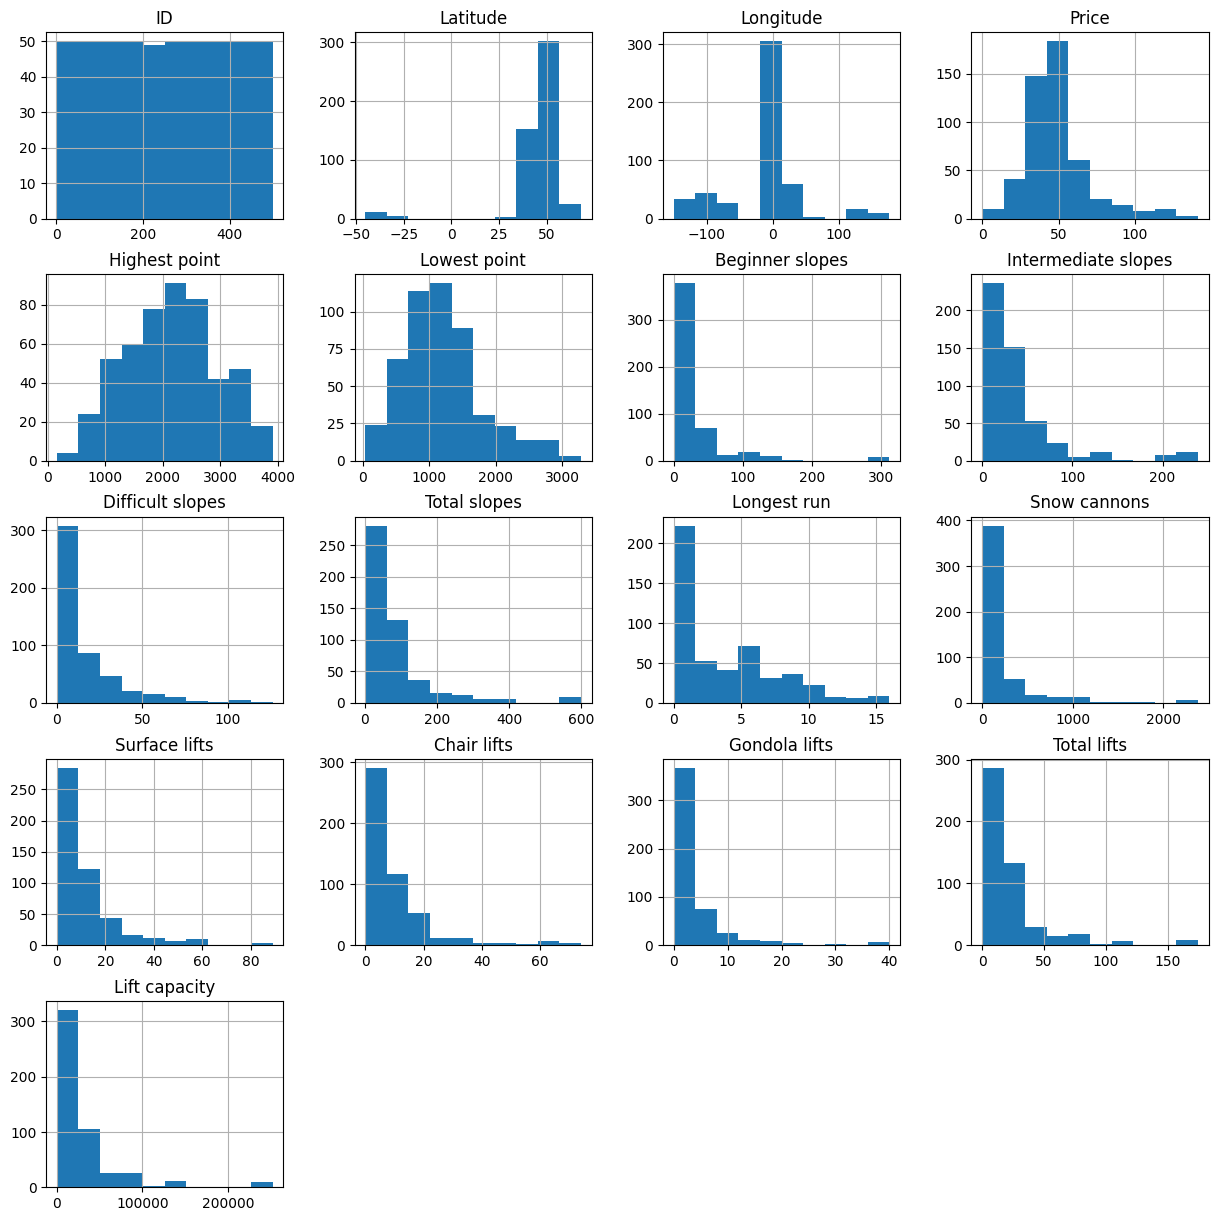

In [14]:
raw_data.hist(figsize=(15,15))

We can see a lot of this data is skewed to the left, meaning most resorts have a low number value of each feature. The ID is evenly distributed across all resorts because every resort has a unique ID. We don't need to worry about that since we dropped that column in the transformed data.

/var/folders/6w/g9wtvzks4n95s0fbwlpy68xc0000gn/T/ipykernel_74556/3284844335.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.values, y=country_counts.index, palette="viridis")


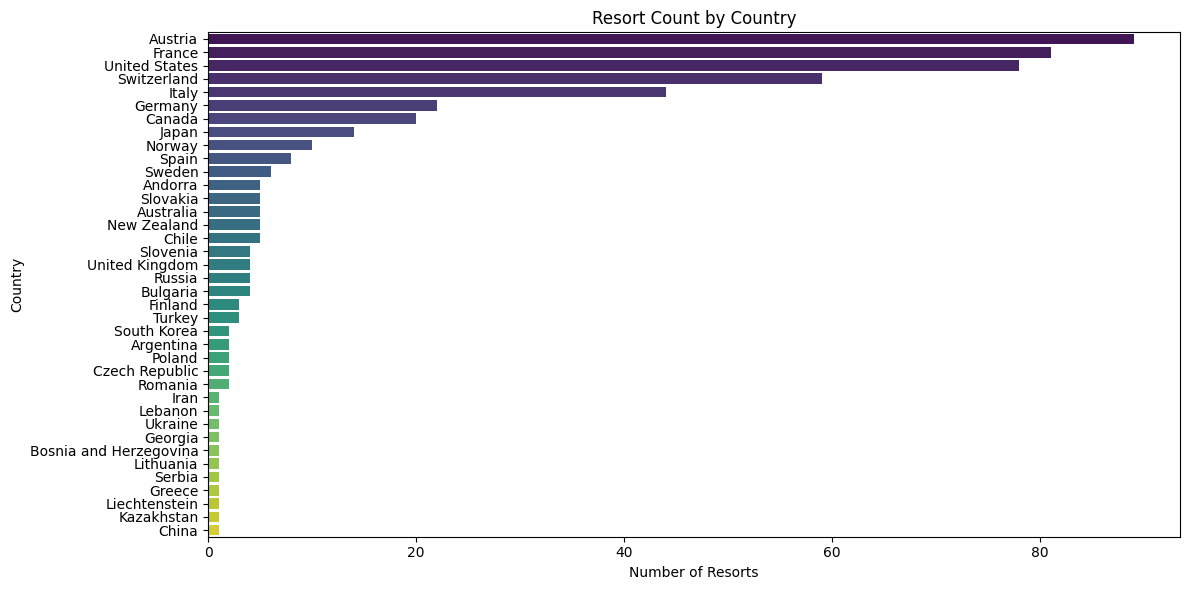

In [15]:
country_counts = raw_data["Country"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=country_counts.values, y=country_counts.index, palette="viridis")
plt.xlabel("Number of Resorts")
plt.ylabel("Country")
plt.title("Resort Count by Country")
plt.tight_layout()
plt.show()

The graph above shows that the majority of resorts are in Austria, France, USA, Switzerland, and Italy.

Next lets see if we can Identify any coorelations between the features. For this we can implement a heatmap.

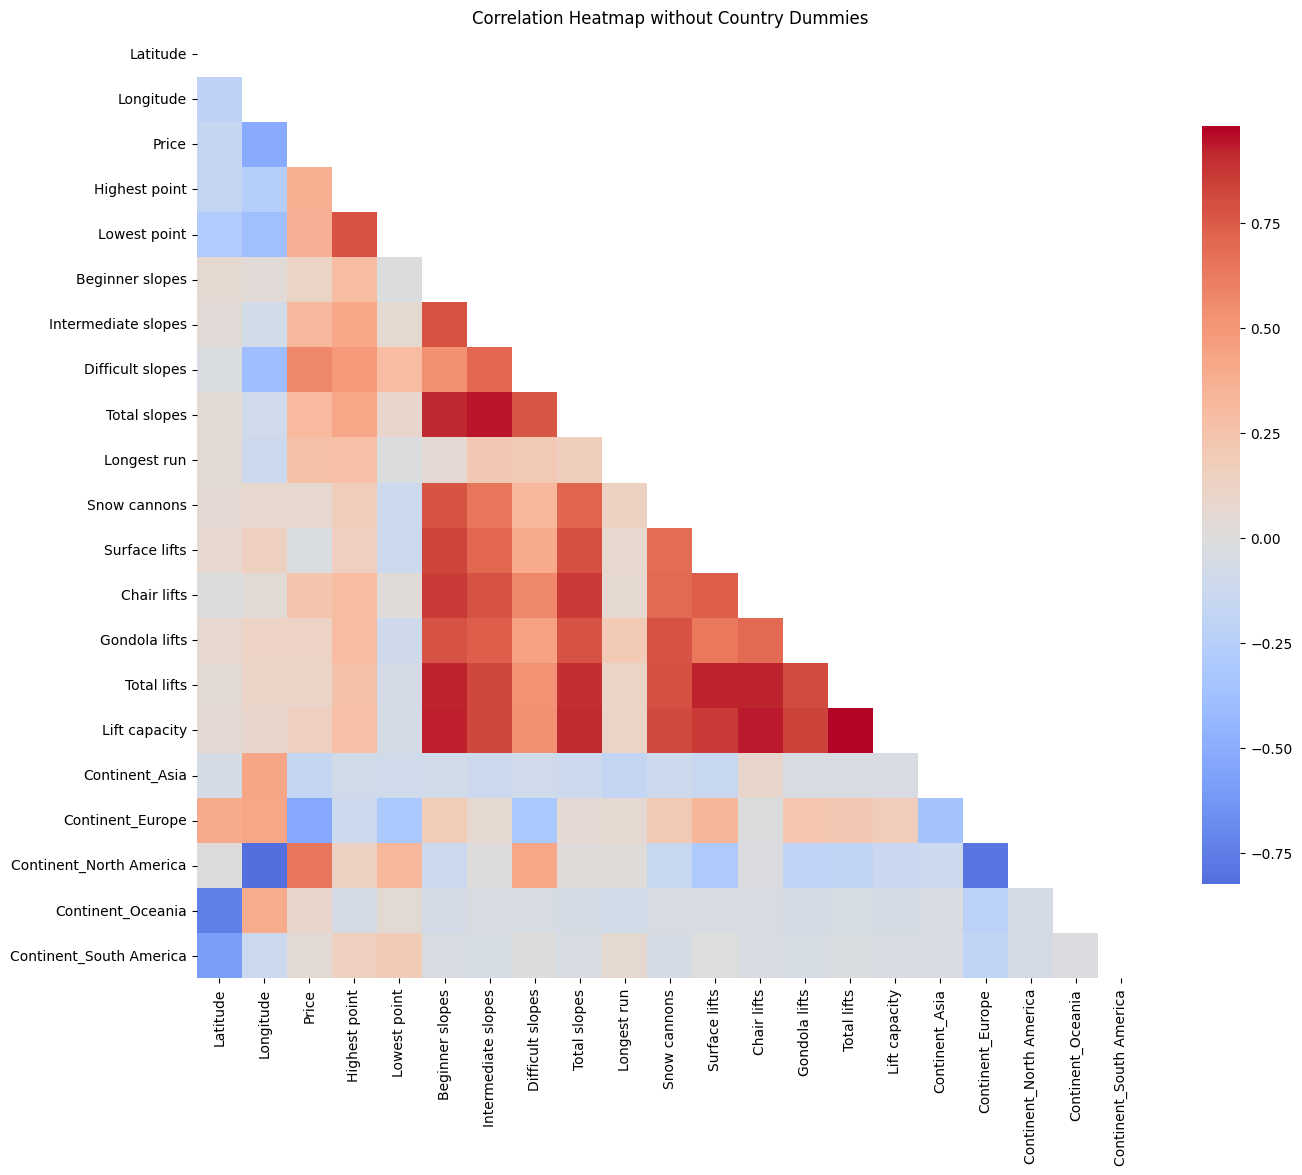

In [16]:
country_cols = [col for col in df_encoded.columns if col.startswith('Country_')] # drop country dummies
feature_subset = df_encoded.drop(columns=country_cols)
feature_subset = feature_subset.drop(columns=['ID']) # drop ID if present
corr_matrix = feature_subset.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0, annot=False, square=True, cbar_kws={'shrink': 0.75})
plt.title('Correlation Heatmap without Country Dummies')
plt.tight_layout()

Above we can see a lot of good information. The red pixels represent positive correlations. There appears to be a strong positive correlation between the number of lifts and the number of slopes. This makes sense because the more slopes exist, the more lifts are required to deliver skiers to the slopes.

Likewise there is a strong negative correlation between Latitude and the Australian continent. That also makes sense because as Latitude increases, we are moving North, further away from Australia.

Looking at Price, our target prediction, we see the is a moderate negative correlation with Longitude, and a moderate positive correlation with the North America Continent. It seems resorts in North America may command a higher price than other locations.

/var/folders/6w/g9wtvzks4n95s0fbwlpy68xc0000gn/T/ipykernel_74556/736058274.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_corr.values, y=country_corr.index, palette='coolwarm_r')


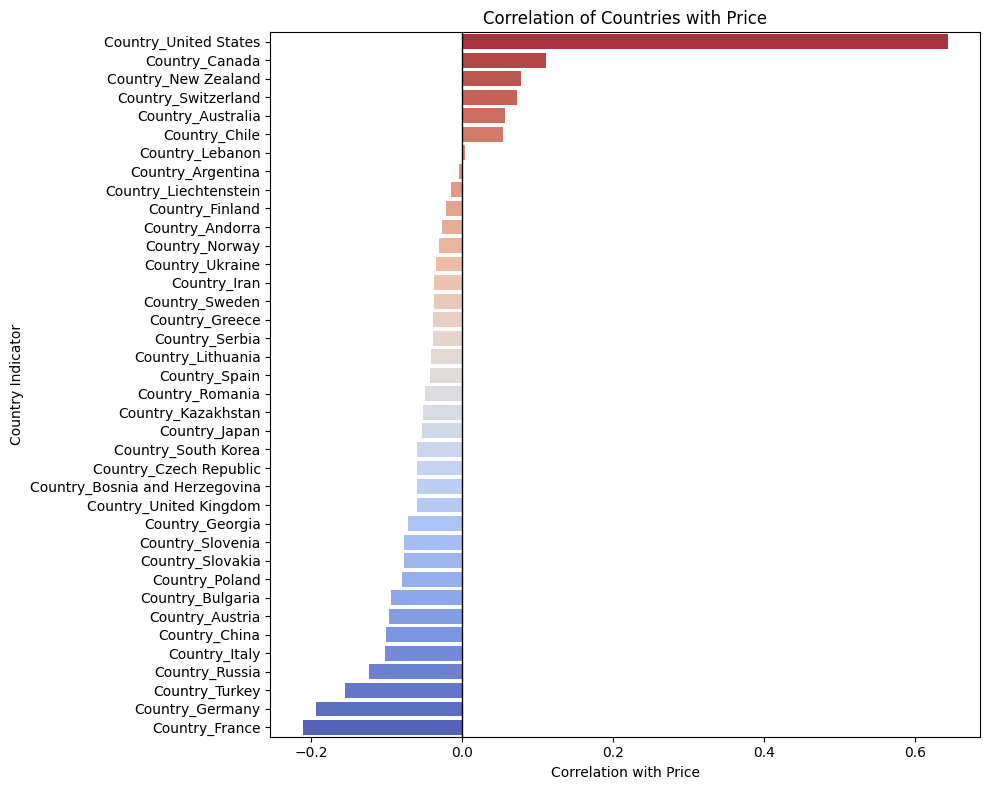

In [17]:

country_cols = [col for col in df_encoded.columns if col.startswith('Country_')]
base = df_encoded.drop(columns=['ID'])

country_corr = base[country_cols + ['Price']].corr(numeric_only=True)['Price'].drop('Price')
country_corr = country_corr.sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=country_corr.values, y=country_corr.index, palette='coolwarm_r')
plt.axvline(0, color='black', linewidth=1)
plt.title('Correlation of Countries with Price')
plt.xlabel('Correlation with Price')
plt.ylabel('Country Indicator')
plt.tight_layout()

We can see here again that USA has the strongest correlation with price, while France has the strongest negative correlation with price.

From these details we can suspect that if a resort is located in the United States, it will most likely have a higher price. Next lets move on to training our machine learning model predictor!

## Machine Learning Model Development (Training)

In this section we will take our processed data, split it into training and test data to validate its accuraccy when predicting prices. For this we will train the model on 80% of the data, then test it against the remaining 20% to determine its accuracy.

In [18]:
from sklearn.model_selection import train_test_split

x = df.drop(['Price'], axis=1) # x is all columns except Price
y = df['Price'] # y is just the Price column

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2) # split the df into training 80% and test 20% sets

train_data = x_train.join(y_train)

train_data.head()

,Latitude,Longitude,Highest point,Lowest point,Beginner slopes,Intermediate slopes,Difficult slopes,Total slopes,Longest run,Snow cannons,...,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,SeasonStart_sin,SeasonStart_cos,SeasonEnd_sin,SeasonEnd_cos,Price
388,46.302609,5.940747,900,640,16,7,4,27,0,120,...,0,1,0,0,0,-2.449294e-16,1.000000,1.000000,6.123234e-17,28
242,46.731048,12.327947,2200,1130,17,39,18,74,4,250,...,0,1,0,0,0,-5.000000e-01,0.866025,0.866025,-5.000000e-01,51
407,45.596710,25.556189,1799,1021,5,2,5,12,0,145,...,0,1,0,0,0,-2.449294e-16,1.000000,0.866025,-5.000000e-01,32
55,60.216882,6.435787,1460,1200,2,2,0,4,0,0,...,0,1,0,0,0,5.000000e-01,-0.866025,-1.000000,-1.836970e-16,42
328,46.770050,9.067384,2418,1110,13,33,3,49,7,100,...,0,1,0,0,0,-2.449294e-16,1.000000,1.000000,6.123234e-17,49


Now that the data is split, we can fit the training data portion to the Linear Regression model.

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train, y_train = train_data.drop(['Price'], axis=1), train_data['Price']
x_train_s = scaler.fit_transform(x_train)

reg = LinearRegression()
reg.fit(x_train_s, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


We've successfully trained our Linear Regression model! Lets remove Price from the test data and review its information.

In [20]:
test_data = x_test.join(y_test)
x_test, y_test = test_data.drop(['Price'], axis=1), test_data['Price']
x_test_s = scaler.transform(x_test)

test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 251 to 239
Data columns (total 67 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Latitude                        91 non-null     float64
 1   Longitude                       91 non-null     float64
 2   Highest point                   91 non-null     int64  
 3   Lowest point                    91 non-null     int64  
 4   Beginner slopes                 91 non-null     int64  
 5   Intermediate slopes             91 non-null     int64  
 6   Difficult slopes                91 non-null     int64  
 7   Total slopes                    91 non-null     int64  
 8   Longest run                     91 non-null     int64  
 9   Snow cannons                    91 non-null     int64  
 10  Surface lifts                   91 non-null     int64  
 11  Chair lifts                     91 non-null     int64  
 12  Gondola lifts                   91 non-n

## Machine Learning Model Development (Testing)

Our test data will measure the accuracy of the model using 91 data points. Lets score it.

In [21]:
reg.score(x_test_s, y_test) 

0.6521567684887247

Above you can see the percentage accuracy of the Linear Regression algorithm

Lets try another alogrithm to see if we can increase its accuracy.  This time we can try a Random Forest Regression instead.

In [22]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()

forest.fit(x_train_s, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
forest.score(x_test_s, y_test)

0.8053323189111614

Above we can see we achieved a greater accuracy using a Random Forest Regression algorithm! For our inference strategy, we will stick with the Random Forest model due to its increased accuracy.

## Predicting our Ski Resort Price

For our predictions we will leverage the Random Forest Regressor algorithm. Instead of splitting the data for testing, we can use all the available data to train this model. This will help us get the most accurate prediction as possible.

In [24]:
x, y = df.drop(['Price'], axis=1), df['Price']
x_s = scaler.fit_transform(x)
forest.fit(x_s, y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Now that the model is trained we need to provide a sample resort. Our resort input format will match the original data columns we encountered at the beginning.

In [25]:
new_resort = {
    "ID": 999,
    "Resort": "Example Peak",
    "Latitude": 47.50,
    "Longitude": 11.35,
    "Country": "United States",
    "Continent": "North America",
    # "Price": None,  # leave None; the model will predict this
    "Season": "December - April",
    "Highest point": 2100,
    "Lowest point": 800,
    "Beginner slopes": 18,
    "Intermediate slopes": 32,
    "Difficult slopes": 12,
    "Total slopes": 62,
    "Longest run": 7,
    "Snow cannons": 150,
    "Surface lifts": 8,
    "Chair lifts": 12,
    "Gondola lifts": 3,
    "Total lifts": 23,
    "Lift capacity": 18000,
    "Child friendly": "Yes",
    "Snowparks": "Yes",
    "Nightskiing": "No",
    "Summer skiing": "No",
}

Above represents the ski resort we want to price check. Below is the script to reformat the input for the machine learning model.

In [26]:
MONTH_TO_NUM = {
    "January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11, "December": 12,
}
BINARY_COLS = ["Child friendly", "Snowparks", "Nightskiing", "Summer skiing"]
BINARY_MAP = {"Yes": 1, "No": 0}
SEASON_PATTERN = r"^\s*[A-Za-z]+(?: [A-Za-z]+)*\s*-\s*[A-Za-z]+(?: [A-Za-z]+)*\s*$"

def preprocess_resort_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    processed = df.copy()
    processed = processed.drop(columns=["ID", "Resort"], errors="ignore")

    for col in BINARY_COLS:
        if col in processed.columns:
            processed[col] = processed[col].map(BINARY_MAP).astype("Int64")

    processed = pd.get_dummies(
        processed,
        columns=[col for col in ["Country", "Continent"] if col in processed.columns],
        drop_first=False,
    )
    bool_cols = processed.select_dtypes(include=["bool"]).columns
    if len(bool_cols):
        processed[bool_cols] = processed[bool_cols].astype("int8")

    if "Season" in processed.columns:
        processed["Season"] = (
            processed["Season"]
            .astype(str)
            .str.replace("\u2013", "-", regex=False)
            .str.replace("\u2014", "-", regex=False)
            .str.strip()
        )
        if not processed["Season"].str.match(SEASON_PATTERN, na=False).all():
            bad_rows = processed.index[
                ~processed["Season"].str.match(SEASON_PATTERN, na=False)
            ].tolist()
            raise ValueError(
                f"Season strings not in 'Start - End' format for rows: {bad_rows}"
            )

        season_parts = processed["Season"].str.extract(
            r"^\s*(?P<SeasonStart>.+?)\s*-\s*(?P<SeasonEnd>.+?)\s*$"
        )
        processed = processed.join(season_parts).drop(columns=["Season"])

        processed["SeasonStart"] = processed["SeasonStart"].map(MONTH_TO_NUM)
        processed["SeasonEnd"] = processed["SeasonEnd"].map(MONTH_TO_NUM)

        processed["SeasonStart_sin"] = np.sin(
            2 * np.pi * processed["SeasonStart"] / 12
        )
        processed["SeasonStart_cos"] = np.cos(
            2 * np.pi * processed["SeasonStart"] / 12
        )
        processed["SeasonEnd_sin"] = np.sin(
            2 * np.pi * processed["SeasonEnd"] / 12
        )
        processed["SeasonEnd_cos"] = np.cos(
            2 * np.pi * processed["SeasonEnd"] / 12
        )

        processed = processed.drop(columns=["SeasonStart", "SeasonEnd"])
        processed = processed.dropna(
            subset=["SeasonStart_sin", "SeasonStart_cos", "SeasonEnd_sin", "SeasonEnd_cos"]
        )

    return processed


In [27]:
input_df = pd.DataFrame([new_resort])
processed_input = preprocess_resort_dataframe(input_df)

print(processed_input.shape)
display(processed_input.head())

feature_columns = [
    "Latitude", "Longitude", "Highest point", "Lowest point",
    "Beginner slopes", "Intermediate slopes", "Difficult slopes",
    "Total slopes", "Longest run", "Snow cannons", "Surface lifts",
    "Chair lifts", "Gondola lifts", "Total lifts", "Lift capacity",
    "Child friendly", "Snowparks", "Nightskiing", "Summer skiing",
    "Country_Andorra", "Country_Argentina", "Country_Australia",
    "Country_Austria", "Country_Bosnia and Herzegovina",
    "Country_Bulgaria", "Country_Canada", "Country_Chile",
    "Country_China", "Country_Czech Republic", "Country_Finland",
    "Country_France", "Country_Georgia", "Country_Germany",
    "Country_Greece", "Country_Iran", "Country_Italy",
    "Country_Japan", "Country_Kazakhstan", "Country_Lebanon",
    "Country_Liechtenstein", "Country_Lithuania", "Country_New Zealand",
    "Country_Norway", "Country_Poland", "Country_Romania",
    "Country_Russia", "Country_Serbia", "Country_Slovakia",
    "Country_Slovenia", "Country_South Korea", "Country_Spain",
    "Country_Sweden", "Country_Switzerland", "Country_Turkey",
    "Country_Ukraine", "Country_United Kingdom", "Country_United States",
    "Continent_Asia", "Continent_Europe", "Continent_North America",
    "Continent_Oceania", "Continent_South America",
    "SeasonStart_sin", "SeasonStart_cos", "SeasonEnd_sin", "SeasonEnd_cos"
]
# If you already captured the feature column order from training:
processed_input = processed_input.reindex(columns=feature_columns, fill_value=0)


(1, 25)


,Latitude,Longitude,Highest point,Lowest point,Beginner slopes,Intermediate slopes,Difficult slopes,Total slopes,Longest run,Snow cannons,...,Child friendly,Snowparks,Nightskiing,Summer skiing,Country_United States,Continent_North America,SeasonStart_sin,SeasonStart_cos,SeasonEnd_sin,SeasonEnd_cos
0,47.5,11.35,2100,800,18,32,12,62,7,150,...,1,1,0,0,1,1,-2.449294e-16,1.0,0.866025,-0.5


In [28]:
scaled_input = scaler.transform(processed_input)
predicted_price = forest.predict(scaled_input)[0]

print(f"Predicted day-pass price: ${predicted_price:.2f}")

Predicted day-pass price: $70.26


## Let's Make Some Predictions!

Finally we can leverage the model to make predictions for resorts with varying features. The code script below creates a form for user input, parses the data, and performs the model inference. Use the input form below the script to retrieve estimated daily lift prices using different ski resort features.

In [29]:
import ipywidgets as widgets
from IPython.display import display, clear_output

country_options = sorted(raw_data["Country"].unique())
country_to_continent = (
    raw_data.drop_duplicates("Country").set_index("Country")["Continent"].to_dict()
)
month_options = [
    "January","February","March","April","May","June",
    "July","August","September","October","November","December"
]
label_style = {"description_width": "160px"}

form = {
    "Latitude": widgets.FloatText(description="Latitude", style=label_style),
    "Longitude": widgets.FloatText(description="Longitude", style=label_style),
    "Country": widgets.Dropdown(description="Country", options=country_options, style=label_style),
    "SeasonStart": widgets.Dropdown(description="Season Start", options=month_options, style=label_style),
    "SeasonEnd": widgets.Dropdown(description="Season End", options=month_options, style=label_style),
    "Highest point": widgets.IntText(description="Highest point (m)", style=label_style),
    "Lowest point": widgets.IntText(description="Lowest point (m)", style=label_style),
    "Beginner slopes": widgets.IntText(description="# Beginner slopes", style=label_style),
    "Intermediate slopes": widgets.IntText(description="# Intermediate slopes", style=label_style),
    "Difficult slopes": widgets.IntText(description="# Difficult slopes", style=label_style),
    "Longest run": widgets.FloatText(description="Longest run (km)", style=label_style),
    "Snow cannons": widgets.IntText(description="# Snow cannons", style=label_style),
    "Surface lifts": widgets.IntText(description="# Surface lifts", style=label_style),
    "Chair lifts": widgets.IntText(description="# Chair lifts", style=label_style),
    "Gondola lifts": widgets.IntText(description="# Gondola lifts", style=label_style),
    "Lift capacity": widgets.IntText(description="Lift capacity", style=label_style),
    "Child friendly": widgets.ToggleButtons(description="Child friendly", options=["Yes","No"], style=label_style),
    "Snowparks": widgets.ToggleButtons(description="Snowparks", options=["Yes","No"], style=label_style),
    "Nightskiing": widgets.ToggleButtons(description="Nightskiing", options=["Yes","No"], style=label_style),
    "Summer skiing": widgets.ToggleButtons(description="Summer skiing", options=["Yes","No"], style=label_style),
}

submit_btn = widgets.Button(description="Predict price", button_style="success")
output = widgets.Output()

def on_submit(_):
    with output:
        clear_output()
        user_input = {key: widget.value for key, widget in form.items()}

        country = user_input["Country"]
        user_input["Continent"] = country_to_continent.get(country, "Unknown")

        user_input["Season"] = f"{user_input.pop('SeasonStart')} - {user_input.pop('SeasonEnd')}"
        user_input["Total slopes"] = (
            user_input["Beginner slopes"]
            + user_input["Intermediate slopes"]
            + user_input["Difficult slopes"]
        )
        user_input["Total lifts"] = (
            user_input["Surface lifts"]
            + user_input["Chair lifts"]
            + user_input["Gondola lifts"]
        )

        user_input["ID"] = 0
        user_input["Resort"] = "Notebook Input"
        user_input["Price"] = None

        processed = preprocess_resort_dataframe(pd.DataFrame([user_input]))
        processed = processed.reindex(columns=feature_columns, fill_value=0)
        scaled = scaler.transform(processed)
        pred = forest.predict(scaled)[0]
        print(f"Estimated day-pass price: ${pred:.2f}")

submit_btn.on_click(on_submit)

title = widgets.HTML("<h3>Daily Lift Price Prediction Engine</h3>")
display(widgets.VBox([title] + list(form.values()) + [submit_btn, output]))


Using this form we can predict the daily lift pass for a resort with different features. 

Some business use cases could include:    
- Estimating prices of ski passes given existing resort features.
- Estimate changes in daily pass value when adding new features or changing existing features
- Estimate prices when expanding moutain size.
- Estimating the return on investment on a specific feature

Business strategists can make data driven decisions based on the features of their resort to estimate the value of their lift passes, or they can see how adjustment of certain resort features might influence day-pass value.

